# タイタニックの生存予測  
https://signate.jp/competitions/102/

## ライブラリのインストール

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

交差検証の説明  
https://data-analysis-stats.jp/python/%E3%83%9B%E3%83%BC%E3%83%AB%E3%83%89%E3%82%A2%E3%82%A6%E3%83%88%E6%A4%9C%E8%A8%BC%E3%81%A8%E4%BA%A4%E5%B7%AE%E6%A4%9C%E8%A8%BC/

## データの読み込み

In [2]:
train = pd.read_csv("train.tsv", sep="\t", index_col=0) # 学習用データ
test = pd.read_csv("test.tsv", sep="\t", index_col=0)   # 評価用データ
sample_submit = pd.read_csv("sample_submit.tsv", sep="\t", index_col=0, header=None) # 応募用サンプルファイル

In [3]:
train.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked
id,,,,,,,,
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
7,0,3,male,2.0,3,1,21.0750,S
9,1,2,female,14.0,1,0,30.0708,C
11,1,1,female,58.0,0,0,26.5500,S


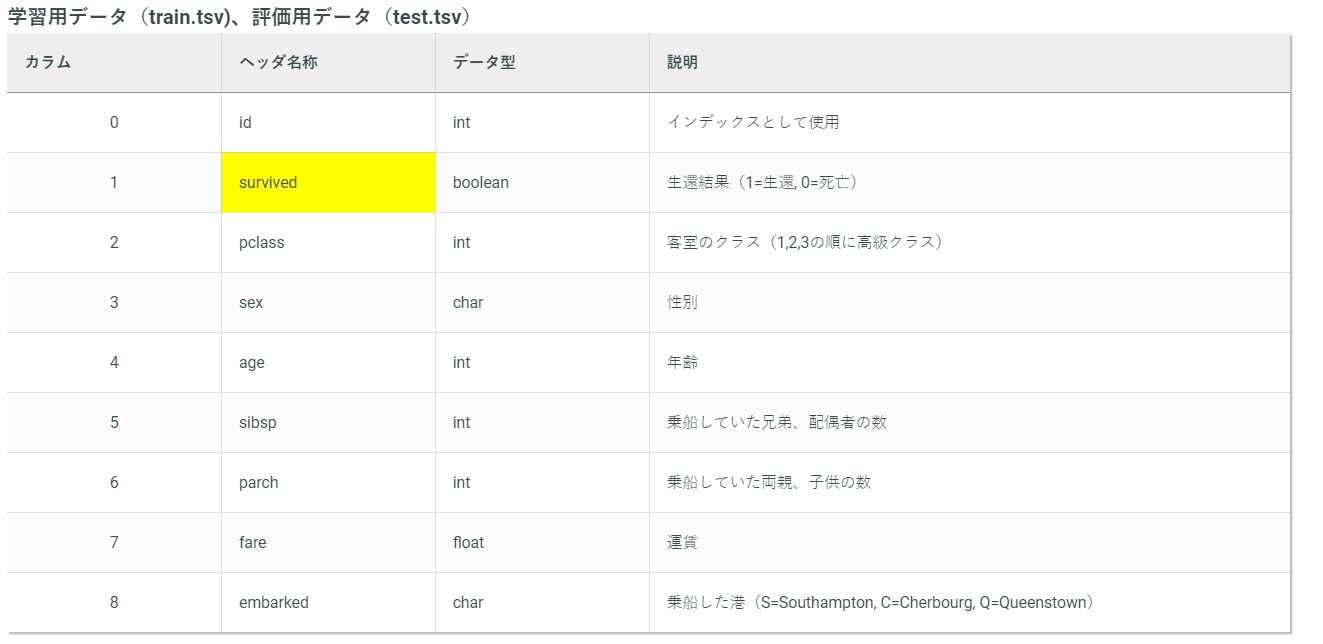

In [4]:
#skleanのver次第でLabelEncoderでエラーが出る可能性があるため追加
train.dropna(subset=["embarked"], inplace=True)
#train = train[~train["embarked"].isnull()]

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 443 entries, 3 to 888
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  443 non-null    int64  
 1   pclass    443 non-null    int64  
 2   sex       443 non-null    object 
 3   age       358 non-null    float64
 4   sibsp     443 non-null    int64  
 5   parch     443 non-null    int64  
 6   fare      443 non-null    float64
 7   embarked  443 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 31.1+ KB


## データの前処理

In [6]:
le = LabelEncoder()
train["sex"] = le.fit_transform(train["sex"])
le.classes_

array(['female', 'male'], dtype=object)

In [7]:
le = LabelEncoder()
train["embarked"] = le.fit_transform(train["embarked"])
le.classes_

array(['C', 'Q', 'S'], dtype=object)

In [8]:
train

,survived,pclass,sex,age,sibsp,parch,fare,embarked
id,,,,,,,,
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2
7,0,3,1,2.0,3,1,21.0750,2
9,1,2,0,14.0,1,0,30.0708,0
11,1,1,0,58.0,0,0,26.5500,2
...,...,...,...,...,...,...,...,...
873,0,3,1,47.0,0,0,9.0000,2
874,1,2,0,28.0,1,0,24.0000,0
879,1,1,0,56.0,0,1,83.1583,0


In [9]:
data = train.drop(["survived", "age"], axis=1)
data

,pclass,sex,sibsp,parch,fare,embarked
id,,,,,,
3,1,0,1,0,53.1000,2
4,3,1,0,0,8.0500,2
7,3,1,3,1,21.0750,2
9,2,0,1,0,30.0708,0
11,1,0,0,0,26.5500,2
...,...,...,...,...,...,...
873,3,1,0,0,9.0000,2
874,2,0,1,0,24.0000,0
879,1,0,0,1,83.1583,0


In [10]:
target = train["survived"]
target

id
3      1
4      0
7      0
9      1
11     1
      ..
873    0
874    1
879    1
884    0
888    0
Name: survived, Length: 443, dtype: int64

In [11]:
kf = KFold(n_splits=5, shuffle=True, random_state=1) 

In [12]:
for train_index, test_index in kf.split(data):
    print(test_index)

[  4   5   6  17  18  29  31  40  47  58  62  65  67  78  90 101 102 107
 119 128 132 139 146 159 164 168 171 172 174 179 185 186 187 204 207 208
 213 214 218 221 223 229 233 236 238 247 250 256 257 268 270 272 274 283
 284 285 286 287 289 290 293 295 298 303 305 309 312 332 337 343 353 360
 365 368 370 374 378 386 389 392 397 401 409 415 421 429 432 438 440]
[ 11  12  13  14  23  27  39  41  46  59  61  66  69  73  80  81  82  85
  88  89  91  92  93  95  98 106 117 120 122 123 124 125 127 131 138 157
 161 162 165 173 180 189 191 192 197 201 206 225 228 249 258 261 275 277
 291 294 296 300 307 311 314 315 325 327 328 329 331 338 339 340 344 347
 349 350 366 372 381 382 385 394 400 404 419 423 424 425 426 439 442]
[  0   8   9  16  19  28  32  33  34  35  38  42  44  48  51  53  55  70
  79  84  99 100 105 108 110 111 112 113 135 142 145 147 150 154 158 160
 163 167 169 175 188 211 222 224 227 230 232 242 244 245 246 251 260 267
 273 299 304 306 310 323 324 326 341 342 345 351 354 355 

In [13]:
data.loc[4] #index名で取得

pclass      3.00
sex         1.00
sibsp       0.00
parch       0.00
fare        8.05
embarked    2.00
Name: 4, dtype: float64

In [14]:
data.iloc[2] #行番号で取得

pclass       3.000
sex          1.000
sibsp        3.000
parch        1.000
fare        21.075
embarked     2.000
Name: 7, dtype: float64

In [15]:
data.iloc[[0,3,6,9]] #リストで渡せば複数行取得

,pclass,sex,sibsp,parch,fare,embarked
id,,,,,,
3,1,0,1,0,53.1000,2
9,2,0,1,0,30.0708,0
16,3,1,4,1,29.1250,1
24,3,0,3,1,21.0750,2


## 交差検証で確認

In [16]:
model = LogisticRegression()
auc_ave = []

for train_index, valid_index in kf.split(data):
    
    X_train = data.iloc[train_index]
    X_valid = data.iloc[valid_index]
    
    y_train = target.iloc[train_index]
    y_valid = target.iloc[valid_index]
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_valid)
    
    auc = roc_auc_score(y_valid, y_pred)
    auc_ave.append(auc)
    
    print(auc)

print("ave:{:.3f}".format(np.mean(auc_ave)))

0.827807486631016
0.7744949494949496
0.707452725250278
0.786522911051213
0.7030303030303031
ave:0.760


In [17]:
model = LogisticRegression()

scores = cross_val_score(
    model,
    data,
    target,
    scoring='roc_auc',
    cv=5,
)

scores

array([0.89648847, 0.85875262, 0.7510582 , 0.84123989, 0.83989218])

In [18]:
np.mean(scores)

0.83748627333533

## 年齢の情報を追加

In [19]:
#ageの欠損を確認
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 443 entries, 3 to 888
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  443 non-null    int64  
 1   pclass    443 non-null    int64  
 2   sex       443 non-null    int32  
 3   age       358 non-null    float64
 4   sibsp     443 non-null    int64  
 5   parch     443 non-null    int64  
 6   fare      443 non-null    float64
 7   embarked  443 non-null    int32  
dtypes: float64(2), int32(2), int64(4)
memory usage: 43.9 KB


In [20]:
train["age"].mean()

29.0954469273743

In [21]:
train["age"] = train["age"].fillna(train["age"].mean())

In [22]:
train

,survived,pclass,sex,age,sibsp,parch,fare,embarked
id,,,,,,,,
3,1,1,0,35.000000,1,0,53.1000,2
4,0,3,1,35.000000,0,0,8.0500,2
7,0,3,1,2.000000,3,1,21.0750,2
9,1,2,0,14.000000,1,0,30.0708,0
11,1,1,0,58.000000,0,0,26.5500,2
...,...,...,...,...,...,...,...,...
873,0,3,1,47.000000,0,0,9.0000,2
874,1,2,0,28.000000,1,0,24.0000,0
879,1,1,0,56.000000,0,1,83.1583,0


In [23]:
data = train.drop(["survived"], axis=1)
target = train["survived"]

In [24]:
#年齢を追加
model = LogisticRegression()
auc_ave = []

for train_index, valid_index in kf.split(data):
    
    X_train = data.iloc[train_index]
    X_valid = data.iloc[valid_index]
    
    y_train = target.iloc[train_index]
    y_valid = target.iloc[valid_index]
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_valid)
    
    auc = roc_auc_score(y_valid, y_pred)
    auc_ave.append(auc)
    
    print(auc)

print("ave:{:.3f}".format(np.mean(auc_ave)))

0.8606951871657753
0.7856060606060606
0.7472191323692992
0.8102425876010781
0.6818181818181819
ave:0.777


## 年齢層の情報を追加

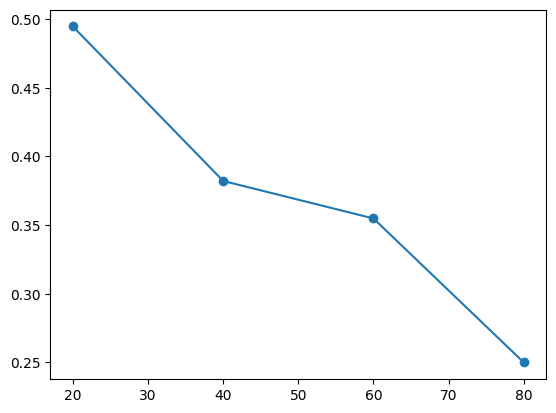

In [25]:
bins = [0, 20, 40, 60, 80]
age_mean = train[["age", "survived"]].groupby(pd.cut(train["age"], bins=bins)).mean()
plt.plot(bins[1:], age_mean["survived"], marker="o")
#age_mean

In [26]:
train["age_label"] = pd.cut(train["age"], bins=bins, labels=False)
train

,survived,pclass,sex,age,sibsp,parch,fare,embarked,age_label
id,,,,,,,,,
3,1,1,0,35.000000,1,0,53.1000,2,1
4,0,3,1,35.000000,0,0,8.0500,2,1
7,0,3,1,2.000000,3,1,21.0750,2,0
9,1,2,0,14.000000,1,0,30.0708,0,0
11,1,1,0,58.000000,0,0,26.5500,2,2
...,...,...,...,...,...,...,...,...,...
873,0,3,1,47.000000,0,0,9.0000,2,2
874,1,2,0,28.000000,1,0,24.0000,0,1
879,1,1,0,56.000000,0,1,83.1583,0,2


In [27]:
#年齢層の特徴量を追加

data = train.drop(["survived", "age"], axis=1)
target = train["survived"]

model = LogisticRegression()
auc_ave = []

for train_index, valid_index in kf.split(data):
    
    X_train = data.iloc[train_index]
    X_valid = data.iloc[valid_index]
    
    y_train = target.iloc[train_index]
    y_valid = target.iloc[valid_index]
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_valid)
    
    auc = roc_auc_score(y_valid, y_pred)
    auc_ave.append(auc)
    
    print(auc)

print("ave:{:.3f}".format(np.mean(auc_ave)))

0.8663101604278075
0.7856060606060606
0.7472191323692992
0.8102425876010781
0.7151515151515151
ave:0.785


## 家族の情報を追加

In [28]:
train["family"] = train["sibsp"] + train["parch"] +1
train

,survived,pclass,sex,age,sibsp,parch,fare,embarked,age_label,family
id,,,,,,,,,,
3,1,1,0,35.000000,1,0,53.1000,2,1,2
4,0,3,1,35.000000,0,0,8.0500,2,1,1
7,0,3,1,2.000000,3,1,21.0750,2,0,5
9,1,2,0,14.000000,1,0,30.0708,0,0,2
11,1,1,0,58.000000,0,0,26.5500,2,2,1
...,...,...,...,...,...,...,...,...,...,...
873,0,3,1,47.000000,0,0,9.0000,2,2,1
874,1,2,0,28.000000,1,0,24.0000,0,1,2
879,1,1,0,56.000000,0,1,83.1583,0,2,2


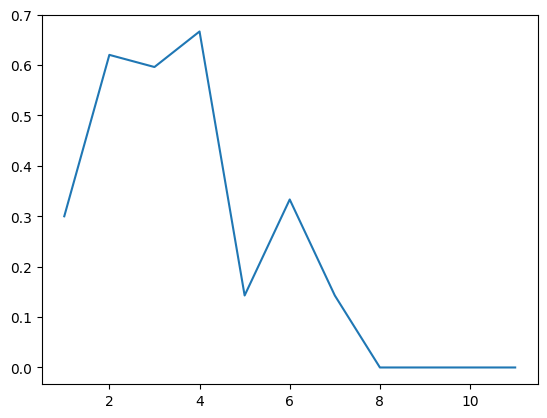

In [29]:
family = train[["survived", "family"]].groupby("family").mean()
plt.plot(family)

In [30]:
#家族の人数の特徴量を追加

data = train.drop(["survived", "age", "sibsp", "parch"], axis=1)
target = train["survived"]

model = LogisticRegression()
auc_ave = []

for train_index, valid_index in kf.split(data):
    
    X_train = data.iloc[train_index]
    X_valid = data.iloc[valid_index]
    
    y_train = target.iloc[train_index]
    y_valid = target.iloc[valid_index]
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_valid)
    
    auc = roc_auc_score(y_valid, y_pred)
    auc_ave.append(auc)
    
    print(auc)

print("ave:{:.3f}".format(np.mean(auc_ave)))

0.8754010695187165
0.7856060606060606
0.7633481646273637
0.8102425876010781
0.7212121212121212
ave:0.791


## アウトプットを生存確率に変更

In [31]:
y_pred

array([0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0],
      dtype=int64)

In [32]:
model.predict_proba(X_valid)

array([[0.91618406, 0.08381594],
       [0.04450992, 0.95549008],
       [0.23009634, 0.76990366],
       [0.94588611, 0.05411389],
       [0.23654719, 0.76345281],
       [0.13814119, 0.86185881],
       [0.8664899 , 0.1335101 ],
       [0.79014742, 0.20985258],
       [0.85168771, 0.14831229],
       [0.91618406, 0.08381594],
       [0.91618406, 0.08381594],
       [0.11869224, 0.88130776],
       [0.54901137, 0.45098863],
       [0.24587584, 0.75412416],
       [0.32208067, 0.67791933],
       [0.79870805, 0.20129195],
       [0.96262036, 0.03737964],
       [0.46124703, 0.53875297],
       [0.55646805, 0.44353195],
       [0.86711829, 0.13288171],
       [0.88933369, 0.11066631],
       [0.63603729, 0.36396271],
       [0.78319082, 0.21680918],
       [0.40032886, 0.59967114],
       [0.34195179, 0.65804821],
       [0.79715919, 0.20284081],
       [0.55152075, 0.44847925],
       [0.8892623 , 0.1107377 ],
       [0.28683617, 0.71316383],
       [0.03256355, 0.96743645],
       [0.

In [33]:
data = train.drop(["survived", "age", "sibsp", "parch"], axis=1)
target = train["survived"]

model = LogisticRegression()
auc_ave = []

for train_index, valid_index in kf.split(data):
    
    X_train = data.iloc[train_index]
    X_valid = data.iloc[valid_index]
    
    y_train = target.iloc[train_index]
    y_valid = target.iloc[valid_index]
    
    model.fit(X_train, y_train)
    
    #y_pred = model.predict(X_valid)
    y_pred = model.predict_proba(X_valid)[:, 1]
    
    auc = roc_auc_score(y_valid, y_pred)
    auc_ave.append(auc)
    
    print(auc)

print("ave:{:.3f}".format(np.mean(auc_ave)))

0.9411764705882354
0.8494949494949495
0.82146829810901
0.8706199460916442
0.7382920110192838
ave:0.844


## 各項目の影響度を確認

In [34]:
model = LogisticRegression()
model.fit(data, target)

LogisticRegression()

In [35]:
#1を基準とし、差異が影響度
coefficients = model.coef_[0]
odds_ratios = np.exp(coefficients)
for feature, odds_ratio in zip(data.columns, odds_ratios):
    print(f"{feature}: {odds_ratio}")

pclass: 0.420921213577958
sex: 0.08075388028888947
fare: 1.0034906597171478
embarked: 0.7434418550499761
age_label: 0.5500139424219183
family: 0.8408742785520716


## モデルのパラメータを調整

グリッドサーチで最適パラメータを探索  
https://di-acc2.com/programming/python/8465/

In [36]:
#調整したいハイパーパラメータ
parameters = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'], #4条件
    'C': [0.001, 0.01, 0.1, 1, 10, 100], #6条件
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], #5条件
    'max_iter': [100, 200, 300, 400, 500] #5条件
}

#全部で600条件(4*6*5*5)

詳細は以下を確認（ただし英語）  
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [37]:
model = LogisticRegression()

In [38]:
grid_search = GridSearchCV(model, parameters, scoring="roc_auc", cv=5)

In [39]:
data

,pclass,sex,fare,embarked,age_label,family
id,,,,,,
3,1,0,53.1000,2,1,2
4,3,1,8.0500,2,1,1
7,3,1,21.0750,2,0,5
9,2,0,30.0708,0,0,2
11,1,0,26.5500,2,2,1
...,...,...,...,...,...,...
873,3,1,9.0000,2,2,1
874,2,0,24.0000,0,1,2
879,1,0,83.1583,0,2,2


In [40]:
grid_search.fit(data, target)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 200, 300, 400, 500],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='roc_auc')

In [41]:
pd.DataFrame(grid_search.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
mean_fit_time,0.001213,0.000791,0.005239,0.0,0.011523,0.012798,0.00666,0.000357,0.009723,0.013519,...,0.000691,0.000735,0.0,0.0,0.00324,0.023337,0.023126,0.0,0.038142,0.04101
std_fit_time,0.000509,0.000661,0.003227,0.0,0.009111,0.012038,0.008157,0.000523,0.006544,0.006798,...,0.000963,0.001029,0.0,0.0,0.006479,0.008588,0.006427,0.0,0.006366,0.016103
mean_score_time,0.0,0.0,0.002652,0.0,0.001527,0.0,0.006475,0.003168,0.0,0.003567,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005214,0.003428
std_score_time,0.0,0.0,0.001276,0.0,0.001695,0.0,0.007931,0.006336,0.0,0.006349,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006139,0.003089
param_C,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,100,100,100,100,100,100,100,100,100,100
param_max_iter,100,100,100,100,100,100,100,100,100,100,...,500,500,500,500,500,500,500,500,500,500
param_penalty,l1,l1,l1,l1,l1,l2,l2,l2,l2,l2,...,elasticnet,elasticnet,elasticnet,elasticnet,elasticnet,none,none,none,none,none
param_solver,newton-cg,lbfgs,liblinear,sag,saga,newton-cg,lbfgs,liblinear,sag,saga,...,newton-cg,lbfgs,liblinear,sag,saga,newton-cg,lbfgs,liblinear,sag,saga
params,"{'C': 0.001, 'max_iter': 100, 'penalty': 'l1',...","{'C': 0.001, 'max_iter': 100, 'penalty': 'l1',...","{'C': 0.001, 'max_iter': 100, 'penalty': 'l1',...","{'C': 0.001, 'max_iter': 100, 'penalty': 'l1',...","{'C': 0.001, 'max_iter': 100, 'penalty': 'l1',...","{'C': 0.001, 'max_iter': 100, 'penalty': 'l2',...","{'C': 0.001, 'max_iter': 100, 'penalty': 'l2',...","{'C': 0.001, 'max_iter': 100, 'penalty': 'l2',...","{'C': 0.001, 'max_iter': 100, 'penalty': 'l2',...","{'C': 0.001, 'max_iter': 100, 'penalty': 'l2',...",...,"{'C': 100, 'max_iter': 500, 'penalty': 'elasti...","{'C': 100, 'max_iter': 500, 'penalty': 'elasti...","{'C': 100, 'max_iter': 500, 'penalty': 'elasti...","{'C': 100, 'max_iter': 500, 'penalty': 'elasti...","{'C': 100, 'max_iter': 500, 'penalty': 'elasti...","{'C': 100, 'max_iter': 500, 'penalty': 'none',...","{'C': 100, 'max_iter': 500, 'penalty': 'none',...","{'C': 100, 'max_iter': 500, 'penalty': 'none',...","{'C': 100, 'max_iter': 500, 'penalty': 'none',...","{'C': 100, 'max_iter': 500, 'penalty': 'none',..."
split0_test_score,NaN,NaN,0.569969,NaN,0.569969,0.678459,0.678459,0.772799,0.756551,0.7424,...,NaN,NaN,NaN,NaN,NaN,0.89544,0.89544,NaN,0.806866,0.789046


In [42]:
best_params = grid_search.best_params_
best_params

{'C': 1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}

In [43]:
result = pd.DataFrame(grid_search.cv_results_)
result[result["rank_test_score"]==1].T

,302,322,342,362,382
mean_fit_time,0.007672,0.003611,0.003238,0.0,0.007821
std_fit_time,0.009596,0.006498,0.006476,0.0,0.00625
mean_score_time,0.001407,0.003442,0.003242,0.006513,0.003668
std_score_time,0.002814,0.006884,0.006485,0.007977,0.002893
param_C,1,1,1,1,1
param_max_iter,100,200,300,400,500
param_penalty,l1,l1,l1,l1,l1
param_solver,liblinear,liblinear,liblinear,liblinear,liblinear
params,"{'C': 1, 'max_iter': 100, 'penalty': 'l1', 'so...","{'C': 1, 'max_iter': 200, 'penalty': 'l1', 'so...","{'C': 1, 'max_iter': 300, 'penalty': 'l1', 'so...","{'C': 1, 'max_iter': 400, 'penalty': 'l1', 'so...","{'C': 1, 'max_iter': 500, 'penalty': 'l1', 'so..."
split0_test_score,0.897537,0.897537,0.897537,0.897537,0.897537


## 最適パラメータで再学習

In [44]:
best_model = LogisticRegression(**best_params)

In [45]:
best_model.fit(data, target)

LogisticRegression(C=1, penalty='l1', solver='liblinear')

## 提出データの作成

In [46]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 446 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    446 non-null    int64  
 1   sex       446 non-null    object 
 2   age       354 non-null    float64
 3   sibsp     446 non-null    int64  
 4   parch     446 non-null    int64  
 5   fare      446 non-null    float64
 6   embarked  446 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 27.9+ KB


In [47]:
le = LabelEncoder()
test["sex"] = le.fit_transform(test["sex"])
le.classes_

array(['female', 'male'], dtype=object)

In [48]:
le = LabelEncoder()
test["embarked"] = le.fit_transform(test["embarked"])
le.classes_

array(['C', 'Q', 'S'], dtype=object)

In [49]:
test["age"] = test["age"].fillna(train["age"].mean())

In [50]:
test["age_label"] = pd.cut(test["age"], bins=bins, labels=False)

In [51]:
test["family"] = test["sibsp"] + test["parch"] +1

In [52]:
test

,pclass,sex,age,sibsp,parch,fare,embarked,age_label,family
id,,,,,,,,,
0,3,1,22.000000,1,0,7.2500,2,1,2
1,1,0,38.000000,1,0,71.2833,0,1,2
2,3,0,26.000000,0,0,7.9250,2,1,1
5,3,1,29.095447,0,0,8.4583,1,1,1
6,1,1,54.000000,0,0,51.8625,2,2,1
...,...,...,...,...,...,...,...,...,...
885,3,0,39.000000,0,5,29.1250,1,1,6
886,2,1,27.000000,0,0,13.0000,2,1,1
887,1,0,19.000000,0,0,30.0000,2,0,1


In [53]:
X_test = test.drop(["age", "sibsp", "parch"], axis=1)
X_test

,pclass,sex,fare,embarked,age_label,family
id,,,,,,
0,3,1,7.2500,2,1,2
1,1,0,71.2833,0,1,2
2,3,0,7.9250,2,1,1
5,3,1,8.4583,1,1,1
6,1,1,51.8625,2,2,1
...,...,...,...,...,...,...
885,3,0,29.1250,1,1,6
886,2,1,13.0000,2,1,1
887,1,0,30.0000,2,0,1


In [54]:
y_submit = best_model.predict_proba(X_test)[:, 1]
y_submit

array([0.101269  , 0.93472713, 0.63156519, 0.14509215, 0.31217761,
       0.55333256, 0.68005437, 0.1830949 , 0.74131412, 0.69591444,
       0.22776881, 0.60243344, 0.23848791, 0.22776881, 0.7837791 ,
       0.58985841, 0.520314  , 0.95296688, 0.54057751, 0.27705445,
       0.11818641, 0.68135768, 0.79690453, 0.59297831, 0.11818641,
       0.1288754 , 0.13967135, 0.71685032, 0.09987969, 0.11806629,
       0.89776181, 0.27710475, 0.41308299, 0.17579733, 0.30705273,
       0.520314  , 0.13614343, 0.78863995, 0.50858966, 0.51108497,
       0.14353305, 0.11799426, 0.11811231, 0.11818641, 0.27437419,
       0.63643525, 0.11888526, 0.51652047, 0.11818641, 0.11818641,
       0.28561075, 0.28595415, 0.51896363, 0.63153384, 0.11811231,
       0.41866004, 0.11847718, 0.08707487, 0.11811231, 0.11805428,
       0.11811231, 0.66333517, 0.70932437, 0.05703897, 0.71613738,
       0.30077991, 0.30101365, 0.11775047, 0.4713492 , 0.77179036,
       0.66852771, 0.63137733, 0.60005576, 0.3287878 , 0.28154

In [55]:
sample_submit

,1
0,
0,0
1,1
2,0
5,1
6,1
...,...
885,1
886,1
887,1


In [56]:
sample_submit[1] = y_submit
sample_submit

,1
0,
0,0.101269
1,0.934727
2,0.631565
5,0.145092
6,0.312178
...,...
885,0.505489
886,0.227769
887,0.936245


In [57]:
sample_submit.to_csv('submit_improve_model.tsv', header=None, sep='\t')